## Create Index

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from elasticsearch import Elasticsearch

data_version = '5'

es = Elasticsearch(['10.60.0.59:9200'], timeout=30)

index_name = f'enwiki-20171001-paragraph-{data_version}'
settings = {
    "settings": {
        "analysis": {
            "analyzer": {
                "en_analyzer": {
                    "type": "standard",
                    "stopwords": "_english_"
                },
                "simple_bigram_analyzer": {
                    "tokenizer": "standard",
                    "filter": ["lowercase", "shingle", "asciifolding"]
                },
                "bigram_analyzer": {
                    "tokenizer": "standard",
                    "filter": ["lowercase", "stop", "shingle", "asciifolding"]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "doc_id": {
                "type": "keyword"
            },
            "url": {
                "type": "keyword"
            },
            "title": {
                "type": "text",
                "similarity": "BM25",
                "analyzer": "simple",
                #"copy_to": "full_text",
                "fields": {
                    "exact": {
                        "type": "keyword"
                    },
                    "bigram": {
                        "type": "text",
                        "similarity": "BM25",
                        "analyzer": "simple_bigram_analyzer",
                    }
                }
            },
            "title_unescaped": {
                "type": "text",
                "similarity": "BM25",
                "analyzer": "simple",
                #"copy_to": "full_text",
                "fields": {
                    "exact": {
                        "type": "keyword"
                    },
                    "bigram": {
                        "type": "text",
                        "similarity": "BM25",
                        "analyzer": "simple_bigram_analyzer",
                    }
                }
            },
            "para_id": {
                "type": "keyword"
            },
            "para_idx": {
                "type": "integer"
            },
            "para_num": {
                "type": "integer"
            },
            "text": {
                "type": "text",
                "similarity": "BM25",
                "analyzer": "en_analyzer",
                #"copy_to": "full_text",
                "fields": {
                    "bigram": {
                        "type": "text",
                        "analyzer": "bigram_analyzer"
                    }
                }
            },
            #"full_text":  {
            #    "type": "text",
            #    "similarity": "BM25",
            #    "analyzer": "en_analyzer"
            #},
            "for_hotpot": {
                "type": "boolean"
            },
            "hyperlinks": {
                "type": "object",
                "enabled": False
            }
        }
    }
}

if es.indices.exists(index_name):
    es.indices.delete(index_name)
es.indices.create(index=index_name, body=settings)

{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'enwiki-20171001-paragraph-5'}

## Load abstract paragraphs HotpotQA

In [3]:
import bz2
import json
import os
from tqdm.auto import tqdm

abs_dir = 'data/HotpotQA/enwiki-20171001-pages-meta-current-withlinks-abstracts/'
files = sorted([os.path.join(abs_dir, dirname, filename)
                for dirname in os.listdir(abs_dir)
                for filename in os.listdir(os.path.join(abs_dir, dirname))])
abstracts = dict()  # id -> text_with_links
for filename in tqdm(files):
    if not os.path.isfile(filename):
        continue
    with bz2.open(filename, 'rb') as fin:
        for line in fin:
            page = json.loads(line)
            if len(page['text_with_links']) == 0:
                assert len(page['text']) == 0
                print(f"Empty abstract paragraph: {page['id']}")
                continue
            if page['id'] in abstracts:
                print(f"duplicate id: {page['id']}")
            abstracts[page['id']] = page['text_with_links']
print(f"#Paragraph (non-empty) in HotpotQA: {len(abstracts):,d}")


#Paragraph (non-empty) in HotpotQA: 5,233,329


## Aggregate Titles

In [4]:
from utils.text_utils import norm_text

titles = set()
titles_file = f'data/corpus/titles-{data_version}.txt'
article_dir = 'data/HotpotQA/enwiki-20171001-pages-meta-current-withlinks-processed/'
files = sorted([os.path.join(article_dir, dirname, filename)
                for dirname in os.listdir(article_dir)
                for filename in os.listdir(os.path.join(article_dir, dirname))])
if not os.path.exists(titles_file):
    n_duplicated = 0
    for filename in tqdm(files):
        if not os.path.isfile(filename):
            continue
        with bz2.open(filename, 'rb') as fin:
            for line in fin:
                page = json.loads(line)
                para_num = len(page['text']) - 1
                assert len(page['charoffset']) == len(page['text'])
                doc_id = page['id']
                if para_num == 0:
                    # print(f"Only has a title: {doc_id} {title}")
                    continue

                title = norm_text(page['title'])
                if title in titles:
                    n_duplicated += 1
                    print(f'Duplicate title: {title}')
                titles.add(title)

    with open(titles_file, 'w') as fout:
        for title in titles:
            fout.write(f"{title}\n")
            fout.flush()
else:
    # Duplicate title: Harry Diamond
    with open(titles_file, 'r') as fin:
        for line in fin:
            title = line.strip()
            if title:
                titles.add(title)

print(f'#Title (valid) in wiki-20171001: {len(titles):,d} + {n_duplicated}')

Duplicate title: Harry Diamond

#Title (valid) in wiki-20171001: 5,474,190 + 1


## Index Paragraphs

In [6]:
import re
from fuzzysearch import find_near_matches


anchor_head = re.compile(r'<a\s+href\s*=\s*"([^<]*?)"\s*>', re.I)
anchor_tail = re.compile(r'</\s*a\s*>', re.I)
broken_head = re.compile(r'<?\s*a?\s+(h\s*r\s*e\s*f|r\s*e\s*f|h\s*e\s*f|h\s*r\s*f|h\s*r\s*e)\s*=?\s*"([^<]*?)"\s*>', re.I)
broken_tail = re.compile(r'<\s*/\s*a\s*[>»]|\s+/\s*a\s*>|<\s*/\s*a\s+', re.I)


def find_closest_substr(src, tgt):
    s = src.find(tgt)
    if s >= 0:
        return s, s + len(tgt), 0

    max_l_dist = 5
    while True:
        matches = find_near_matches(tgt, src, max_l_dist=max_l_dist)
        if len(matches) > 0:
            min_l_dist = max_l_dist + 1
            best_match = None
            for m in matches:
                if m.dist < min_l_dist:
                    min_l_dist = m.dist
                    best_match = m
            return best_match.start, best_match.end, best_match.dist
        else:
            max_l_dist += 5


def find_sentence_spans(paragraph, sentences):
    sentence_spans = [[0, len(paragraph)] for _ in range(len(sentences))]
    for i in range(len(sentences)):
        prefix = ''.join(sentences[:i])
        prefix = anchor_head.sub('', norm_text(prefix))
        prefix = anchor_tail.sub('', prefix)
        prefix = broken_head.sub('', prefix)
        prefix = broken_tail.sub('', prefix)
        prefix = norm_text(prefix)
        suffix = ''.join(sentences[i:])
        suffix = anchor_head.sub('', norm_text(suffix))
        suffix = anchor_tail.sub('', suffix)
        suffix = broken_head.sub('', suffix)
        suffix = broken_tail.sub('', suffix)
        suffix = norm_text(suffix)
        finding_start = len(suffix) >= len(prefix)
        sub_para = suffix if finding_start else prefix
        if i == 0:
            assert finding_start
            s, e, d = find_closest_substr(paragraph, sub_para)
            sentence_spans[0][0] = s
            sentence_spans[-1][1] = e
        else:
            if finding_start:
                offset = sentence_spans[i - 1][0]
                search_space = paragraph[offset:sentence_spans[-1][1]]
                s, e, d = find_closest_substr(search_space, sub_para)
                sentence_spans[i][0] = offset + s
                sentence_spans[i - 1][1] = offset + s
                if offset + e != sentence_spans[-1][1]:
                    print(f"Unexpected fuzzy search:\n{search_space}\n{sub_para}\n{search_space[s:e]}\n")
            else:
                offset = sentence_spans[0][0]
                search_space = paragraph[offset:sentence_spans[-1][1]]
                s, e, d = find_closest_substr(search_space, sub_para)
                sentence_spans[i - 1][1] = offset + e
                sentence_spans[i][0] = offset + e
                if s != 0:
                    print(f"Unexpected fuzzy search:\n{search_space}\n{sub_para}\n{search_space[s:e]}\n")

    return sentence_spans

In [7]:
from collections import defaultdict
from html import unescape
import time
from urllib.parse import unquote
from elasticsearch.helpers import bulk


def act_batch(batch):
    time_start = time.time()
    bulk(es, batch)
    time_end = time.time()
    #print(f'Indexed {len(action_batch)} items, time cost: {time_end - time_start}s')


batch_size = 1000

para_num_bins = defaultdict(list)
link_num_bins = defaultdict(list)
token_num_bins = defaultdict(list)
hotpot_map = dict()

wiki_out = open(f'data/corpus/enwiki-20171001-paragraph-{data_version}.tsv', 'w')  # include some title paragraphs for compatibility with HotpotQA
wiki_out.write("id\ttext\ttitle\thyperlinks\n")
wiki_out.flush()
hotpot_out = open(f'data/corpus/hotpot-paragraph-{data_version}.tsv', 'w')  # only non-empty abstract paragraphs for HotpotQA
hotpot_out.write("id\ttext\ttitle\thyperlinks\tsentence_spans\n")
hotpot_out.flush()

total_num_para = 0
actions = []
for filename in tqdm(files):
    if not os.path.isfile(filename):
        continue
    with bz2.open(filename, 'rb') as fin:
        for line in fin:  # for each document
            page = json.loads(line)
            if len(page['text']) <= 1:
                continue

            doc_id = page['id']
            title = norm_text(page['title'])

            # Check title
            if norm_text(''.join(page['text'][0])) != title:
                print(f"Title 『{norm_text(''.join(page['text'][0]))}』!=『{title}』")
            if title == 'Harry Diamond':
                print(f"{title} {doc_id} {page['url']}")

            abs_strs = abstracts[doc_id] if doc_id in abstracts else None
            found_abs = abs_strs is None

            # Merge some raw paragraphs and pre-pocess text
            paragraphs = []
            p_idx = 1
            while p_idx < len(page['text']):  # for each paragraph
                para_id = f'{doc_id}_{len(paragraphs)}'
                for_hotpot = False

                # Initialize the paragraph with the current paragraph
                sentence_strs = page['text'][p_idx].copy()
                num_raw_token = len(page['charoffset'][p_idx])
                if not found_abs and sentence_strs == abs_strs:
                    for_hotpot = True
                    found_abs = True
                p_idx += 1
                # Append subsequent broken/short paragraphs to the paragraph
                while (p_idx < len(page['text']) and
                       sum(map(len, page['charoffset'][p_idx])) <= max(10, 100 - num_raw_token)):
                    # if sum(map(len, page['charoffset'][p_idx])) >= 10:
                    #     print(f"{para_id}:"
                    #           f"『⋯ {''.join(sentence_strs)[-92:]}』{num_raw_token}+\n"
                    #           f"\t『{''.join(page['text'][p_idx])}』")
                    np_sentence_strs = page['text'][p_idx][:]
                    if not found_abs and np_sentence_strs == abs_strs:
                        for_hotpot = True
                        found_abs = True
                    if len(np_sentence_strs) > 0:
                        np_sentence_strs[0] = ' ' + np_sentence_strs[0]
                        sentence_strs.extend(np_sentence_strs)
                        num_raw_token += sum(map(len, page['charoffset'][p_idx]))
                    p_idx += 1
                para_str = ''.join(sentence_strs)

                # Pre-process the semi-structral text of the paragraph
                para_str = norm_text(para_str)
                para_str = anchor_head.sub(r'┃┊┇┊┃<a href="\1">┃┊┇┊┃', para_str)
                para_str = anchor_tail.sub(r'┃┊┇┊┃</a>┃┊┇┊┃', para_str)
                para_str = broken_head.sub(r'┃┊┇┊┃<a href="\2">┃┊┇┊┃', para_str)
                para_str = broken_tail.sub(r'┃┊┇┊┃</a>┃┊┇┊┃', para_str)

                # Remove html tags and extract hyperlinkers
                target = None
                anchor_segs = None
                para_segs = []
                para_hyperlinks = defaultdict(list)
                for seg in re.split(r'┃┊┇┊┃', para_str):
                    # seg = seg.strip()
                    if not seg:
                        continue

                    match = anchor_head.match(seg)
                    if match:  # anchor head
                        target = norm_text(unquote(match.group(1)))  # xxx
                        anchor_segs = []
                        #if target not in titles:
                        #    target = None
                        #    anchor_segs = None
                    elif anchor_tail.match(seg):  # anchor tail
                        if None in (target, anchor_segs):
                            if target is not None or anchor_segs is not None:
                                print(f"Incomplete <a>:『{anchor_segs}』->『{target}』 {para_str}")
                            continue
                        anchor_text = ''.join(anchor_segs)
                        anchor_text_end = len(''.join(para_segs))
                        para_hyperlinks[target].append({
                            "anchor_text": anchor_text,
                            "span": [anchor_text_end - len(anchor_text), anchor_text_end]
                        })
                        assert ''.join(para_segs)[anchor_text_end - len(anchor_text):anchor_text_end] == anchor_text
                        target = None
                        anchor_segs = None
                    else:  # anchor middle
                        if anchor_segs is not None:
                            anchor_segs.append(seg)
                        para_segs.append(seg)
                if target is not None or anchor_segs is not None:
                    print(f"Unfinished hyperlink in {para_id}: "
                          f"『{None if anchor_segs is None else ''.join(anchor_segs)}』->『{target}』")
                    if anchor_segs is not None and target is not None:
                        anchor_text = ''.join(anchor_segs)
                        anchor_text_end = len(''.join(para_segs))
                        para_hyperlinks[target].append({
                            "anchor_text": anchor_text,
                            "span": [anchor_text_end - len(anchor_text), anchor_text_end]
                        })
                        assert ''.join(para_segs)[anchor_text_end - len(anchor_text):anchor_text_end] == anchor_text
                    target = None
                    anchor_segs = None
                para_text = ''.join(para_segs)  # norm_text()

                # Insert the new paragraph
                if para_text:
                    para_idx = len(paragraphs)
                    paragraphs.append({
                        "doc_id": doc_id,
                        "url": page['url'],
                        "title": title,
                        "title_unescaped": unescape(title),
                        "para_id": para_id,
                        "para_idx": para_idx,
                        "para_num": -1,
                        "text": para_text,
                        "hyperlinks": para_hyperlinks,
                        "for_hotpot": for_hotpot
                    })
                    if for_hotpot:
                        assert abs_strs is not None
                        hotpot_map[doc_id] = {"para_idx": para_idx, "sentence_spans": find_sentence_spans(para_text, abs_strs)}
            para_num = len(paragraphs)
            if para_num == 0:
                found_abs = True

            if not found_abs and page['text'][0] == abs_strs:  # hotpot paragraph is the title
                # add a extra paragraph with idx -1, only used for HotpotQA
                paragraphs.append({
                    "doc_id": doc_id,
                    "url": page['url'],
                    "title": title,
                    "title_unescaped": unescape(title),
                    "para_id": f"{doc_id}_-1",
                    "para_idx": -1,
                    "para_num": -1,
                    "text": title,
                    "hyperlinks": {},
                    "for_hotpot": True
                })
                # To map the sentences of HotpotQA
                hotpot_map[doc_id] = {"para_idx": -1, "sentence_spans": find_sentence_spans(title, abs_strs)}
                found_abs = True
            # Make sure find the abstract paragraph of HotpotQA for support fact prediction
            if not found_abs:
                # Treat the first paragraph as the abstract
                print(f"Can't find the abstract of {doc_id}: 『{''.join(abs_strs)}』")
                # [find_closest_substr(paragraphs[0]['text'], norm_text(sent))[:2] for sent in abs_strs]
                hotpot_map[doc_id] = {"para_idx": 0, "sentence_spans": find_sentence_spans(paragraphs[0]['text'], abs_strs)}
                found_abs = True

            # Count, index and write
            para_num_bins[para_num].append(doc_id)
            if doc_id in hotpot_map:
                abs_para_idx = hotpot_map[doc_id]['para_idx']
                abs_sent_spans = hotpot_map[doc_id]['sentence_spans']
                abs_para = paragraphs[abs_para_idx]
                assert '\t' not in abs_para['text'] and '\t' not in abs_para['title']
                hotpot_out.write(f"{abs_para['para_id']}\t{abs_para['text']}\t{abs_para['title']}\t{json.dumps(abs_para['hyperlinks'])}\t{abs_sent_spans}\n")
                hotpot_out.flush()
            for para in paragraphs:
                link_num_bins[len(para['hyperlinks'])].append(para_id)
                token_num_bins[len(para['text'].split())].append(para_id)
                para['para_num'] = para_num
                #if para['para_idx'] >= 0:  # not the title paragraph
                wiki_out.write(f"{para['para_id']}\t{para['text']}\t{para['title']}\t{json.dumps(para['hyperlinks'])}\n")
                wiki_out.flush()
                actions.append({
                    "_index": index_name,
                    "_id": para['para_id'],
                    "_source": para
                })
                if len(actions) == batch_size:
                        act_batch(actions)
                        total_num_para += len(actions)
                        actions = []

wiki_out.close()
hotpot_out.close()

if len(actions) > 0:
    act_batch(actions)
    total_num_para += len(actions)
    actions = []

print(f'Total {total_num_para} paragraphs indexed in ES')

Unfinished hyperlink in 8522_47: 『2=nd』->『Colorado 's 1st』
Unfinished hyperlink in 27687_63: 『2=nd』->『Missouri 's 1st』
Unfinished hyperlink in 51983_55: 『High Speed』->『High-speed rail in Australia#High-speed rail on the east coast of Australia』
Unfinished hyperlink in 58294_36: 『U』->『U S Congress』
Unfinished hyperlink in 72708_11: 『President Władysław Raczkiewicz』->『Władysław Raczkiewicz』
Unfinished hyperlink in 79759_8: 『2=nd』->『California's 1st』
Unfinished hyperlink in 79770_6: 『2=nd』->『California's 1st』
Unfinished hyperlink in 82023_18: 『2=nd』->『California's 1st』
Unfinished hyperlink in 82028_10: 『2=nd』->『California's 1st』
Unfinished hyperlink in 82097_3: 『2=nd』->『California's 1st』
Unfinished hyperlink in 82107_7: 『2=nd On November 4, 2008, Siskiyou County voted 60.1% for Proposition 8 which amended the California Constitution to ban same-sex marriages.』->『California's 1st』
Unfinished hyperlink in 107591_12: 『2=nd According to Susanville's 2014 Comprehensive Annual Financial Report,

## Count Corpus

#document: 5,457,134 + 17,057


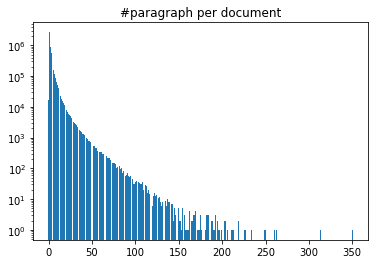

Max 350: 35797415
Avg 3.320143320651463


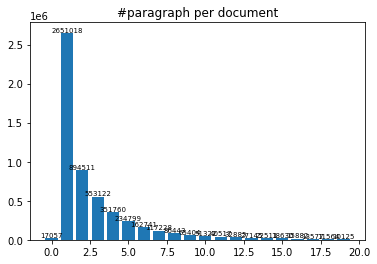

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

doc_num = sum(map(len, para_num_bins.values())) - len(para_num_bins[0])
print(f"#document: {doc_num:,d} + {len(para_num_bins[0]):,d}")  # 5,457,131 + 17,060

x = range(max(para_num_bins.keys()) + 1)
y = [len(para_num_bins[k]) if k in para_num_bins else 0 for k in x]
plt.title('#paragraph per document')
plt.yscale('log')
plt.bar(x, y)
# for a, b in zip(x, y):
#     plt.text(a, b + 0.05, '%d' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.show()
print(f"Max {x[-1]}: {', '.join(para_num_bins[x[-1]])}")  # 35797415
print(f"Avg {sum(k * len(v) for k, v in para_num_bins.items()) / doc_num}")  # 3.32014422963275
# print(f"#0-paragraph: {len(para_num_bins[0])}")

x1 = x[:20]
y1 = y[:20]
plt.title('#paragraph per document')
# plt.yscale('log')
plt.bar(x1, y1)
for a, b in zip(x1, y1):
    plt.text(a, b + 0.05, '%d' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.show()

#paragraph: 18,231,343


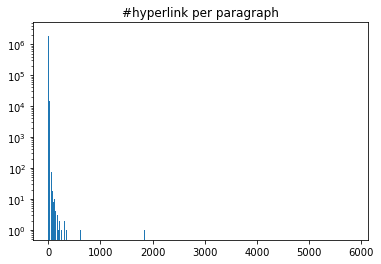

Max 5832: 13931641_0
Avg 4.94174565197967
#0-hyperlink: 2,436,087 (13.36%)


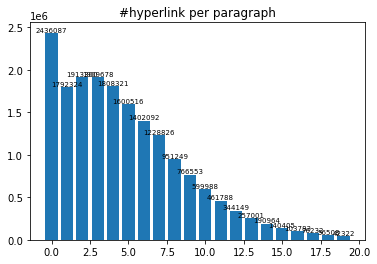

In [9]:
total_para_num = sum(map(len, link_num_bins.values()))
assert total_para_num == es.count(index=index_name, body={"query": {"match_all": {}}})['count']
print(f"#paragraph: {total_para_num:,d}")  # 18,231,338

x = range(max(link_num_bins.keys()) + 1)
y = [len(link_num_bins[k]) if k in link_num_bins else 0 for k in x]
plt.title('#hyperlink per paragraph')
plt.yscale('log')
plt.bar(x, y)
# for a, b in zip(x, y):
#     plt.text(a, b + 0.05, '%d' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.show()
print(f"Max {x[-1]}: {', '.join(link_num_bins[x[-1]])}")  # 13931641_0
print(f"Avg {sum(k * len(v) for k, v in link_num_bins.items()) / total_para_num}")  # 4.941746129658723
print(f"#0-hyperlink: {len(link_num_bins[0]):,d} ({len(link_num_bins[0]) / total_para_num:.2%})")  # 2,436,087 (13.36%)

x1 = x[:20]
y1 = y[:20]
plt.title('#hyperlink per paragraph')
# plt.yscale('log')
plt.bar(x1, y1)
for a, b in zip(x1, y1):
    plt.text(a, b + 0.05, '%d' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.show()

# >=500: 699 (0.003834%)


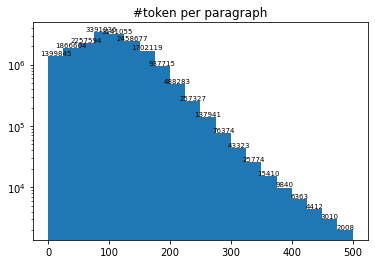

Max 12801: 13931641_0
Avg 105.61552700752765


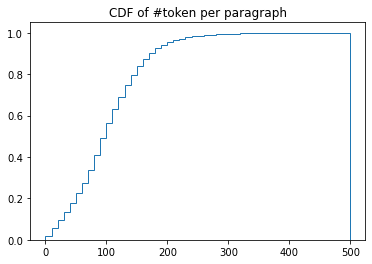

In [10]:
token_nums = []
num_500 = 0
for k, v in token_num_bins.items():
    if k >= 500:
        num_500 += 1
    else:
        token_nums.extend([k] * len(v))
print(f"# >=500: {num_500:,d} ({num_500 / total_para_num:.6%})")  # 708 (0.003883%)

plt.title('#token per paragraph')
counts, bins, patch = plt.hist(token_nums, bins=20, log=True)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.show()
print(f"Max {max(token_num_bins.keys())}: {', '.join(token_num_bins[max(token_num_bins.keys())])}")  # 12837: 13931641_0
print(f"Avg {sum(k * len(v) for k, v in token_num_bins.items()) / total_para_num}")  # 108.52766236904829

plt.title('CDF of #token per paragraph')
plt.hist(token_nums, bins=50, cumulative=True, density=True, histtype='step')
plt.show()